# Electricity Demand Forecasting

Time Series Modeling
In this project I am exploring time series modeling for Electricity Demand Forecasting for the state of California.

This notebook contains the SARIMAX modeling for the daily demand aggregated data.  The data was cleaned and aggregated in the EF_EDA_CleanSplitAgg notebook.

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Module Import](#import)<br>
2. [Data Import](#read_data)<br>
    2A. [Clean Data](#clean_data)<br>
    2B. [Extend Data](#extend_dow)<br>
    2C. [Data Split](#data_split)<br>
3. [Helper Functions](#helper)<br>
4. [Data Analysis](#analysis)<br>
    4A. [Stationarity Testing](#stationarity)<br>
    4B. [Autocorrelation](#autocorr)<br>
    4C. [Seasonal Decomposition](#seasonal_decomp)<br>
5. [Modeling](#modeling)<br>
    5A. [SARIMAX Without Exogenous Data](#SARI_NoX)<br>
    5A.1 [SARIMAX Without Exogenous Data Fit Plot 1](#plot-SARI_fit_zoom)<br>
    5A.2 [SARIMAX Without Exogenous Data Fit Plot 2](#plot-SARI_fit_wide)<br>
    5A.3 [SARIMAX Without Exogeneous Data - Forecast](#forecast-SARI_nox)<br>

    5B. [SARIMAX With Exogeneous Data](#model-SARIMAX-wexog)<br>
    5B.1 [SARIMAX With Exogeneous Data - Fit Plot Close](#plot-SARI_exog_fit_zoom)<br>
    5B.2 [SARIMAX With Exogeneous Data - Fit Plot 3 Month](#plot-SARI_exof_fit_wide)<br>
    5B.3 [SARIMAX With Exogeneous Data - Forecast](#forecast-SARI_exog)<br>

    5C. [SARIMAX With Extended Exogeneous Data](#model-SARI-xexog)<br>
    5C.1 [SARIMAX With Extended Exogeneous Data - Fit Plot Close](#plot-SARI_xexog_fit_zoom)<br>
    5C.2 [SARIMAX With Extended Exogeneous Data - Fit Plot 3 Month](#plot-SARI_xexof_fit_wide)<br>
    5C.3 [SARIMAX With Extended Exogeneous Data - Forecast](#forecast-SARI_xexog)<br>


----

----
### <a id='import'> 1. Module Import </a>

Import the modules used in this notebook.

----

In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict

import pickle
import warnings

from dateutil import parser

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm


from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.statespace.mlemodel

In [2]:
# Eleminate some of the warning messages.
warnings.filterwarnings('ignore')

----
### 2. Data Import <a id='read_data'></a>

Read the data file created by the notebook EF_EDA_CleanSplitAgg.

----


In [3]:
data_file = '../data/big_demand_temp_train_by_day.csv'

In [4]:
full_df = pd.read_csv(data_file, index_col=0)

#### 2A. Clean Data<a id='clean_data'></a>

Most of the data cleaning was done in the script file 
and the Clean-Split-Agg notebook. The next few cells just change 
the data type for the index and extend the exogenous 
variables to include the day of the week.


In [5]:
# Convert the time string to a datetime object
full_df.index = pd.DatetimeIndex(full_df.index)


----

#### 2B. Extend Data<a id='extend_dow'></a>

----


In [6]:
days = full_df['DOW']
days_df = pd.get_dummies(days)
days_df.columns=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
days_df.index = full_df.index
new_df = pd.concat([full_df, days_df], axis=1)
col_names = []
col_names.extend(full_df.columns)
col_names.extend(days_df.columns)
new_df.columns = col_names

----

#### 2C. Data Split <a id='data_split'></a>

----


In [7]:
# Split the data into training and test sections
data_len = new_df.shape[0]

In [8]:
# Split the data frame into two parts
train_len = int(0.7 * data_len)
window_len = int(0.1 * data_len)

In [20]:
# Make the primary train/validation split
X_train = new_df.iloc[:train_len, :]
X_walk1 = new_df.iloc[train_len:train_len+window_len, :]

In [10]:
# Look at the dataframe contents
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 596 entries, 2015-07-06 to 2017-02-20
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   day_demand  596 non-null    float64
 1   CA_pop      596 non-null    float64
 2   la_high     596 non-null    float64
 3   sd_high     596 non-null    float64
 4   sj_high     596 non-null    float64
 5   sf_high     596 non-null    float64
 6   sac_high    596 non-null    float64
 7   f_high      596 non-null    float64
 8   DOW         596 non-null    float64
 9   Mon         596 non-null    uint8  
 10  Tue         596 non-null    uint8  
 11  Wed         596 non-null    uint8  
 12  Thur        596 non-null    uint8  
 13  Fri         596 non-null    uint8  
 14  Sat         596 non-null    uint8  
 15  Sun         596 non-null    uint8  
dtypes: float64(9), uint8(7)
memory usage: 50.6 KB


----

### 3. Helper Functions <a id='helper'></a>

This funtion tests the stationarity of the data set and generates a plot of the test data.

The function was originally published as part of the Blog post

    https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

----


In [11]:
import sys
sys.path.append('../src')
from EF_tools import test_stationarity, order_sweep, top_results

----


### 4. Data Analysis <a id='analysis'></a>

Run through a quick analysis of the data, testing for stationarity and examining the auto regressive characteristics of the data.


___

----

#### 4A. Stationarity Testing <a id='stationarity'></a>

Use the Dickey-Fuller stationarity test to test the input data.  Note that in order
to achieve stationarity I had to take the log of the demand data.

----

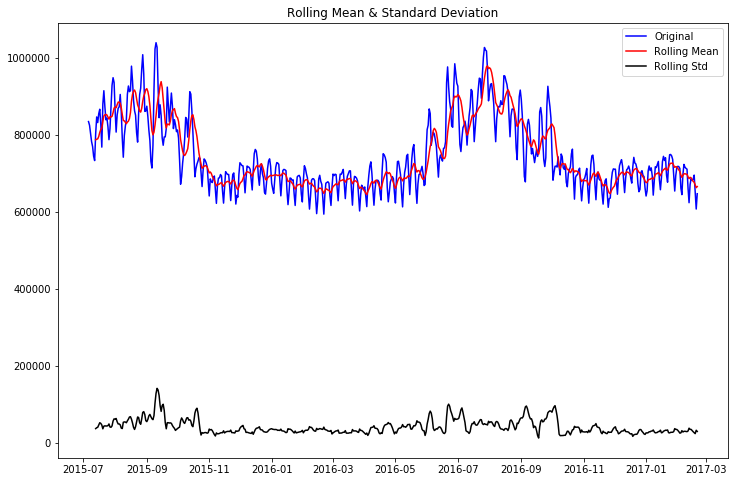

Results of Dickey-Fuller Test:
p-value = 0.4712. The series is likely non-stationary.
Test Statistic                  -1.622938
p-value                          0.471189
#Lags Used                      15.000000
Number of Observations Used    580.000000
Critical Value (1%)             -3.441675
Critical Value (5%)             -2.866536
Critical Value (10%)            -2.569431
dtype: float64


In [12]:
test_stationarity(X_train.day_demand, window=8)

Daily data is not stationary.  Try a simple difference to see if we can get a stationary result

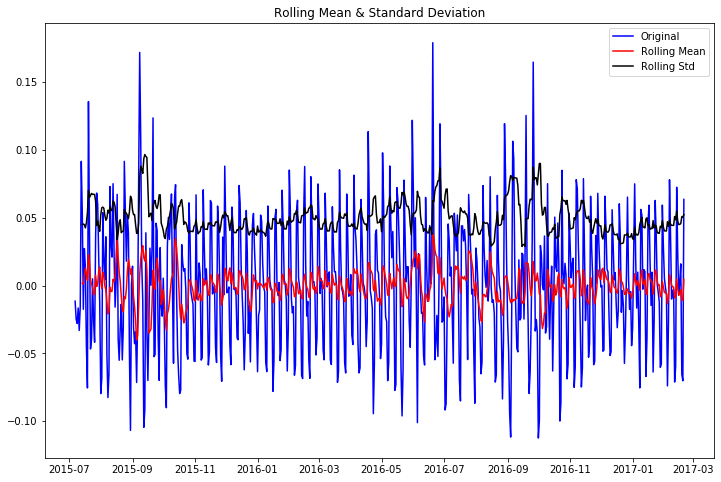

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -5.773402e+00
p-value                        5.327534e-07
#Lags Used                     2.000000e+01
Number of Observations Used    5.740000e+02
Critical Value (1%)           -3.441794e+00
Critical Value (5%)           -2.866588e+00
Critical Value (10%)          -2.569459e+00
dtype: float64


In [13]:
diff_demand_day = X_train.day_demand.diff()[1:]
log_demand = np.log(X_train.day_demand)

test_stationarity(log_demand.diff()[1:], window=8)

Need to take the log of the daily demand to get a stationary time series

----

#### 4B. Autocorrelation <a id='autocorr'></a>

Use autocorrelation to get an idea of the order parameters we may want to test in our model.

-----


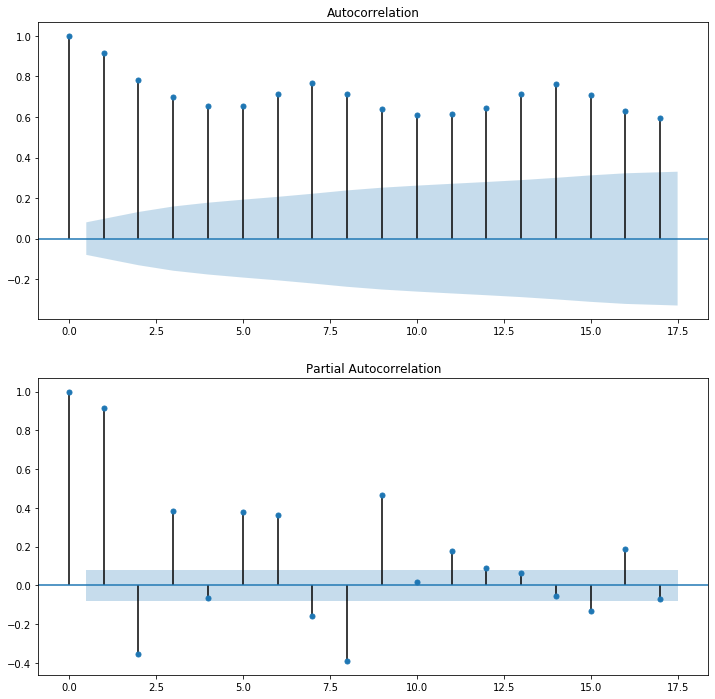

In [14]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_demand, lags=7+10, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_demand, lags=7+10, ax=ax2)# , lags=40

----

#### <a id='seasonal_decomp'>4C. Seasonal Decomposition </a>

----

In [15]:
# Do seasonal decopostion on the weekly periodic features
decomp_data = seasonal_decompose(log_demand, period=7, model='additive')

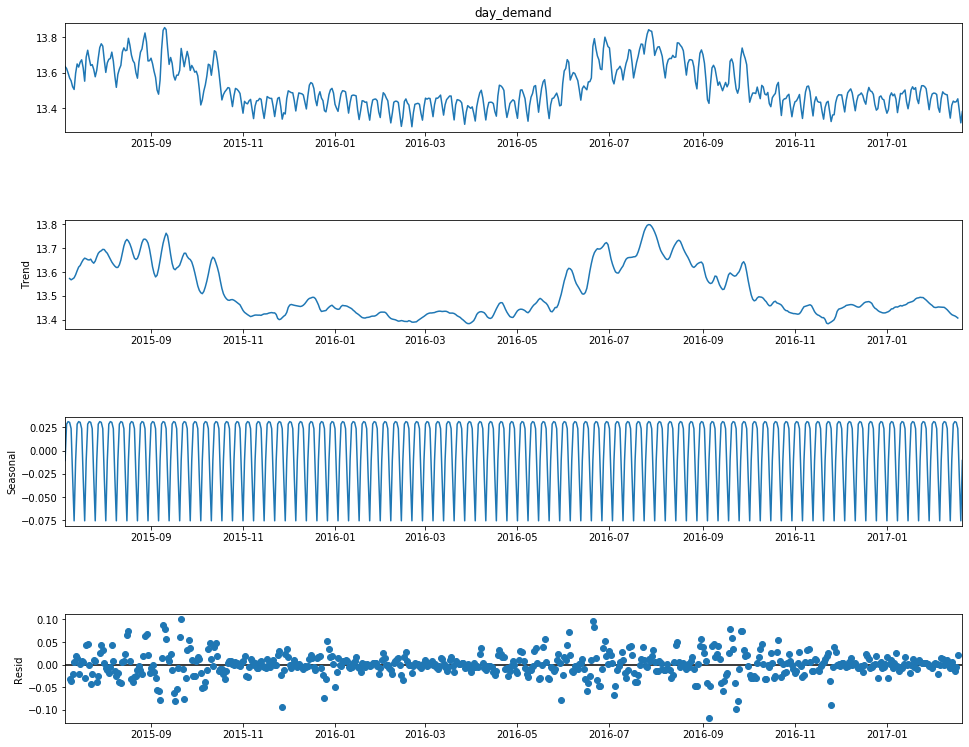

In [16]:
fig = decomp_data.plot()
fig.set_size_inches(15, 12)

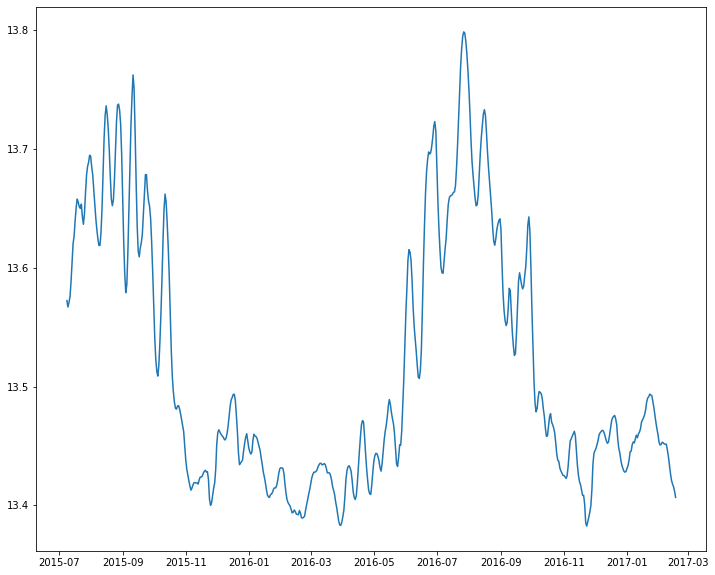

In [17]:
# Plot a closeup of the seasonal component
fig = plt.figure(figsize=[12,10])
plt.plot(decomp_data.trend[:10000])

In [25]:
# Add Log_demand to the dataframe
X_train['log_demand'] = np.log(X_train['day_demand'])

----

### 5. <a id='modeling'>Modeling </a>

In the following cells I do a number of model fits to find the 'best' parameters to include in the final model.

----

#### 5A. <a id='SARI_NoX'>SARIMAX Without Exogeneous Data </a>

In [19]:
# Define the model for SARIMAX just using the demand data
order_list =[(3,0,0),
             (4,0,0),
             (5,0,0),
             (3,1,0),
             (4,1,0),
             (5,1,0),
             (3,0,1),
             (4,0,1),
             (5,0,1),
             (3,1,1),
             (4,1,1),
             (5,1,1)]

# Define the model for SARIMAX just using the demand data
seasonal_list =[(3,0,0, 7),
                (4,0,0, 7),
                (5,0,0, 7),
                (3,1,0, 7),
                (4,1,0, 7),
                (5,1,0, 7),
                (3,0,1, 7),
                (4,0,1, 7),
                (5,0,1, 7),
                (3,1,1, 7),
                (4,1,1, 7),
                (5,1,1, 7)]

result_dict = order_sweep(SARIMAX, order_list, seasonal_list,  endo_data=X_train['log_demand'])


In [21]:
for result in top_results(result_dict, 'aic', 5) :
    print(result)


{'order': (4, 1, 1), 'seasonal order': (4, 1, 1, 7), 'aic': -2634.4122000954367, 'bic': -2586.268203668552, 'mse': 0.38848568678109713}
{'order': (5, 1, 0), 'seasonal order': (4, 1, 1, 7), 'aic': -2625.457916097982, 'bic': -2577.313919671097, 'mse': 0.3884941677548055}
{'order': (5, 1, 0), 'seasonal order': (3, 1, 1, 7), 'aic': -2625.230036494272, 'bic': -2581.462767015286, 'mse': 0.38849663991832223}
{'order': (5, 1, 1), 'seasonal order': (3, 1, 1, 7), 'aic': -2622.892609530773, 'bic': -2574.748613103888, 'mse': 0.3884963230183265}
{'order': (5, 1, 0), 'seasonal order': (5, 0, 1, 7), 'aic': -2614.3462542091015, 'bic': -2561.683517342554, 'mse': 0.31263179841204686}


In [22]:
for result in top_results(result_dict, 'bic', 5) :
    print(result)


{'order': (5, 1, 0), 'seasonal order': (3, 1, 1, 7), 'aic': -2625.230036494272, 'bic': -2581.462767015286, 'mse': 0.38849663991832223}
{'order': (5, 1, 0), 'seasonal order': (4, 1, 1, 7), 'aic': -2625.457916097982, 'bic': -2577.313919671097, 'mse': 0.3884941677548055}
{'order': (5, 1, 1), 'seasonal order': (3, 1, 1, 7), 'aic': -2622.892609530773, 'bic': -2574.748613103888, 'mse': 0.3884963230183265}
{'order': (5, 1, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -2618.1139498986777, 'bic': -2569.8397744376757, 'mse': 0.3126287337908148}
{'order': (4, 0, 0), 'seasonal order': (3, 1, 1, 7), 'aic': -2596.058484512162, 'bic': -2556.6526488592976, 'mse': 2.1642620527728798}


In [23]:
for result in top_results(result_dict, 'mse', 5) :
    print(result)


{'order': (5, 1, 1), 'seasonal order': (5, 0, 0, 7), 'aic': -2623.8556751094943, 'bic': -2571.1929382429466, 'mse': 0.31261956611352343}
{'order': (5, 1, 0), 'seasonal order': (5, 0, 1, 7), 'aic': -2614.3462542091015, 'bic': -2561.683517342554, 'mse': 0.31263179841204686}
{'order': (5, 0, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -2604.2899017969835, 'bic': -2555.9972544592647, 'mse': 0.31263376976906165}
{'order': (4, 1, 0), 'seasonal order': (5, 0, 1, 7), 'aic': -2612.294441788272, 'bic': -2564.02026632727, 'mse': 0.312638152217055}
{'order': (4, 0, 0), 'seasonal order': (5, 0, 1, 7), 'aic': -2584.549101277028, 'bic': -2536.2564539393093, 'mse': 0.31265497219710564}


In [26]:
# Now choose the results that seem to work the best above and fit the model
# The top results above are further evaluated based on coefficient p-values
best_order1 = (4, 1, 1)
best_seasonal_order1 = (5, 0, 0, 7)
model1 = SARIMAX(X_train['log_demand'], order=best_order1, seasonal_order=best_seasonal_order1)
res1 = model1.fit()

In [27]:
print(res1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         log_demand   No. Observations:                  596
Model:             SARIMAX(4, 1, 1)x(5, 0, [], 7)   Log Likelihood                1317.392
Date:                            Tue, 07 Apr 2020   AIC                          -2612.784
Time:                                    15:04:17   BIC                          -2564.510
Sample:                                07-06-2015   HQIC                         -2593.985
                                     - 02-20-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3226      0.058     22.912      0.000       1.209       1.436
ar.L2         -0.7177      0.071   

In [28]:
res1.aic, res1.bic, res1.mse

(-2612.7840297428847, -2564.509854281883, 0.3126362893881732)

In [29]:
# Save the trained model
filename = 'SARIMAX_wo_exog_day.sav'
pickle.dump(model1, open(filename, 'wb'))

In [30]:
demand_hat = np.exp(res1.fittedvalues)

----

##### 5A.1 SARIMAX Without Exogeneous Data - Fit Plot Close <a id='plot-SARI_fit_zoom'></a>

----


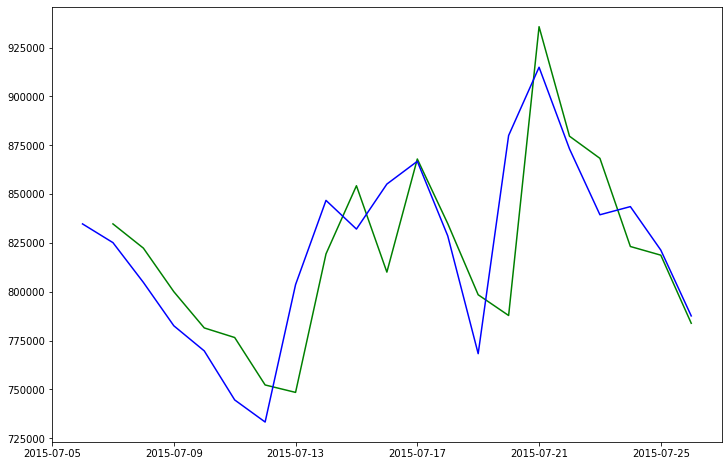

In [31]:
fig = plt.figure(figsize=[12, 8])
close_window = 3*7

plt.plot(demand_hat[1:close_window], label='Predicted', c='g')
plt.plot(X_train.index[:close_window], X_train['day_demand'].values[:close_window], \
         c='b', label='Actual (train)')

----

##### <a id='plot-SARI_fit_wide'>5A.2 SARIMAX Without Exogeneous Data - Fit Plot 3 Months  </a>

----

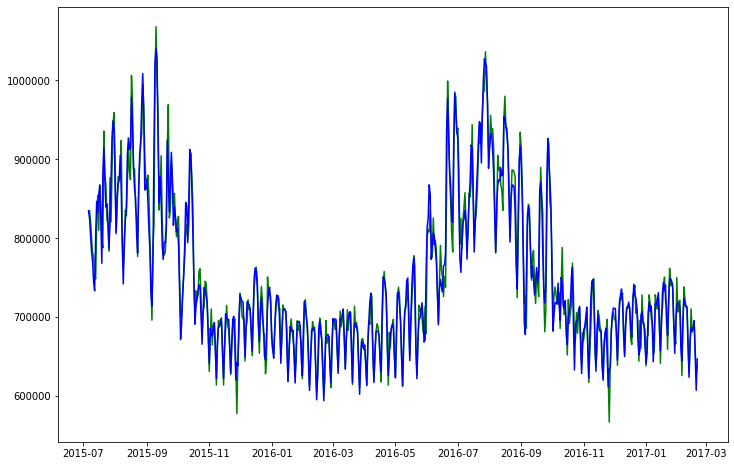

In [32]:
fig = plt.figure(figsize=[12, 8])

plt.plot(demand_hat[1:1000], c='g')
plt.plot(X_train.index[0:1000], X_train['day_demand'].values[0:1000], c='b')

----

##### 5A.3 SARIMAX Without Exogeneous Data - Forecast <a id='forecast-SARI_nox'></a>

----

In [33]:
predict_steps = 7*3
predict1 = res1.get_forecast(predict_steps)
pred_ci1 = np.exp(predict1.conf_int(alpha=0.5))
pred_vals1 = np.exp(predict1.predicted_mean)

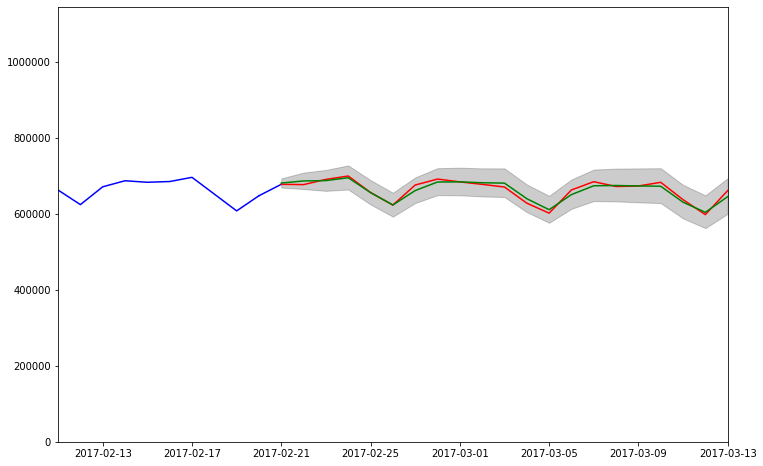

In [34]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci1.iloc[:, 0].values
high_values = pred_ci1.iloc[:, 1].values
pred_times1 = pred_ci1.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times1))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['day_demand']), max(X_walk1['day_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['day_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk1['day_demand'].index[0]], \
          [X_train['day_demand'].values[-1], X_walk1['day_demand'].values[0]], c='b')
plt.plot(X_walk1.index, X_walk1['day_demand'].values, c='r')
plt.plot(pred_times1, pred_vals1.values, c='g')


plt.fill_between(pred_times1, low_values, high_values, color='k', alpha=0.2)

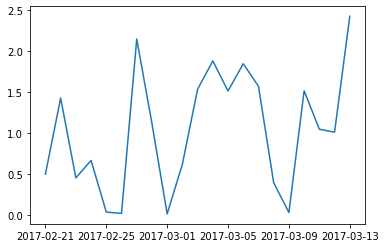

In [35]:
residuals = [abs(X_walk1['day_demand'].values[x] - pred_vals1.values[x]) for x in range(len(pred_vals1))]
percent_error = [residuals[x]/X_walk1['day_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times1, percent_error)
#plt.ylim(0, 7000)

In [36]:
mape1 = np.mean(percent_error[:21])
print(mape1)

1.0363615294314488


----

#### <a id='model-SARIMAX-wexog'>5B. SARIMAX With Exogeneous Data </a>

----

In [37]:
# The trailing columns are city temperatures and state population
important_cities = ['la_high',  'f_high']

In [38]:
# Define the model for SARIMAX just using the demand data
order_list =[(3,0,0),
             (4,0,0),
             (5,0,0),
             (3,1,0),
             (4,1,0),
             (5,1,0),
             (3,0,1),
             (4,0,1),
             (5,0,1),
             (3,1,1),
             (4,1,1)]

# Define the model for SARIMAX just using the demand data
seasonal_list =[(3,0,0, 7),
                (4,0,0, 7),
                (5,0,0, 7),
                (3,1,0, 7),
                (4,1,0, 7),
                (5,1,0, 7),
                (3,0,1, 7),
                (4,0,1, 7),
                (5,0,1, 7)]

result_dict = order_sweep(SARIMAX, order_list, seasonal_list,  \
        endo_data=X_train['log_demand'], exo_data=X_train[important_cities])

#res1 = seasonal_model1.fit()

In [39]:
for result in top_results(result_dict, 'aic', 5) :
    print(result)


{'order': (5, 1, 0), 'seasonal order': (5, 0, 0, 7), 'aic': -2629.543813979293, 'bic': -2572.4925157072, 'mse': 0.30394109100228905}
{'order': (3, 0, 1), 'seasonal order': (5, 1, 0, 7), 'aic': -2628.5513612950535, 'bic': -2576.0102470912343, 'mse': 2.1089242498398293}
{'order': (4, 0, 1), 'seasonal order': (5, 1, 0, 7), 'aic': -2624.667452678847, 'bic': -2567.7479122913765, 'mse': 2.1076430704250795}
{'order': (5, 0, 0), 'seasonal order': (5, 1, 0, 7), 'aic': -2623.9119354818304, 'bic': -2566.99239509436, 'mse': 2.1105718890114167}
{'order': (3, 0, 1), 'seasonal order': (4, 1, 0, 7), 'aic': -2623.105453577383, 'bic': -2574.9427655572154, 'mse': 2.106294257153364}


In [40]:
for result in top_results(result_dict, 'bic', 5) :
    print(result)


{'order': (3, 0, 1), 'seasonal order': (5, 1, 0, 7), 'aic': -2628.5513612950535, 'bic': -2576.0102470912343, 'mse': 2.1089242498398293}
{'order': (3, 0, 0), 'seasonal order': (4, 1, 0, 7), 'aic': -2619.034146346334, 'bic': -2575.2498845098185, 'mse': 2.107498975426424}
{'order': (3, 0, 1), 'seasonal order': (4, 1, 0, 7), 'aic': -2623.105453577383, 'bic': -2574.9427655572154, 'mse': 2.106294257153364}
{'order': (5, 1, 0), 'seasonal order': (5, 0, 0, 7), 'aic': -2629.543813979293, 'bic': -2572.4925157072, 'mse': 0.30394109100228905}
{'order': (3, 0, 0), 'seasonal order': (3, 1, 0, 7), 'aic': -2597.6792070618044, 'bic': -2558.27337140894, 'mse': 2.1101780145293474}


In [41]:
for result in top_results(result_dict, 'mse', 5) :
    print(result)
    

{'order': (4, 0, 1), 'seasonal order': (5, 0, 0, 7), 'aic': -2353.874763749528, 'bic': -2296.8016350776784, 'mse': 0.2945091737147262}
{'order': (3, 0, 1), 'seasonal order': (5, 0, 0, 7), 'aic': -2277.054363827887, 'bic': -2224.3714758231026, 'mse': 0.29460972618272374}
{'order': (3, 0, 1), 'seasonal order': (4, 0, 0, 7), 'aic': -2310.7637039040883, 'bic': -2262.4710565663695, 'mse': 0.2980311282920455}
{'order': (5, 0, 1), 'seasonal order': (5, 0, 0, 7), 'aic': -2500.621508808733, 'bic': -2439.158139469818, 'mse': 0.30081852922567187}
{'order': (5, 1, 0), 'seasonal order': (3, 0, 1, 7), 'aic': -2558.21072531501, 'bic': -2505.5479884484625, 'mse': 0.3024102341734169}


In [45]:
# Now choose the results that seem to work the best above and fit the model
# The top results above are further evaluated based on coefficient p-values
best_order2 = (3, 0, 0)
best_seasonal_order2 = (5, 0, 0, 7)
model2 = SARIMAX(X_train['log_demand'], order=best_order2, seasonal_order=best_seasonal_order2, exog=X_train[important_cities])
res2 = model2.fit()

In [46]:
print(res2.summary())

                                     SARIMAX Results                                     
Dep. Variable:                        log_demand   No. Observations:                  596
Model:             SARIMAX(3, 0, 0)x(5, 0, 0, 7)   Log Likelihood                1177.933
Date:                           Tue, 07 Apr 2020   AIC                          -2333.865
Time:                                   15:40:03   BIC                          -2285.572
Sample:                               07-06-2015   HQIC                         -2315.060
                                    - 02-20-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
la_high        0.0003      0.000      1.123      0.261      -0.000       0.001
f_high         0.0015      0.000      4.968

In [47]:
# Save the trained model
filename = 'SARIMAX_w_exog_day.sav'
pickle.dump(model2, open(filename, 'wb'))

In [48]:
res2.aic

-2333.8650101006897

In [49]:
demand_hat2 = np.exp(res2.fittedvalues)

----
##### 5B.1 <a id='plot-SARI_exog_fit_zoom'>SARIMAX With Exogeneous Data - Fit Plot Close </a>
----

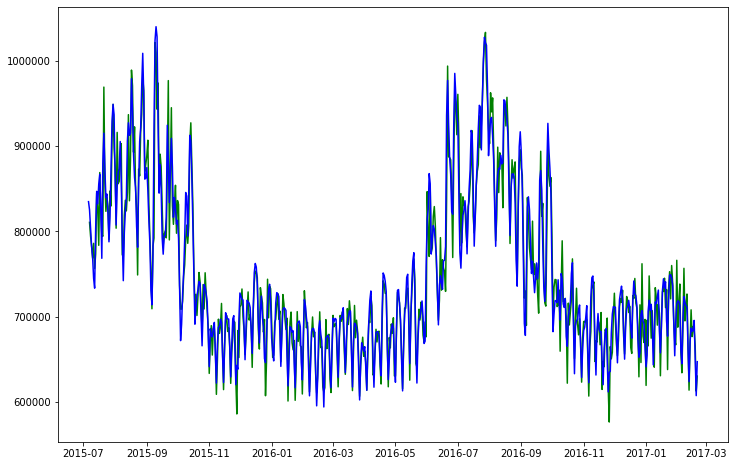

In [50]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(25000, 55000)

plt.plot(demand_hat2[1:], c='g')
plt.plot(X_train.index, X_train['day_demand'].values, c='b')

----

##### <a id='plot-SARI_exof_fit_wide'>5B.2 SARIMAX With Exogeneous Data - Fit Plot 3 Month </a>

----

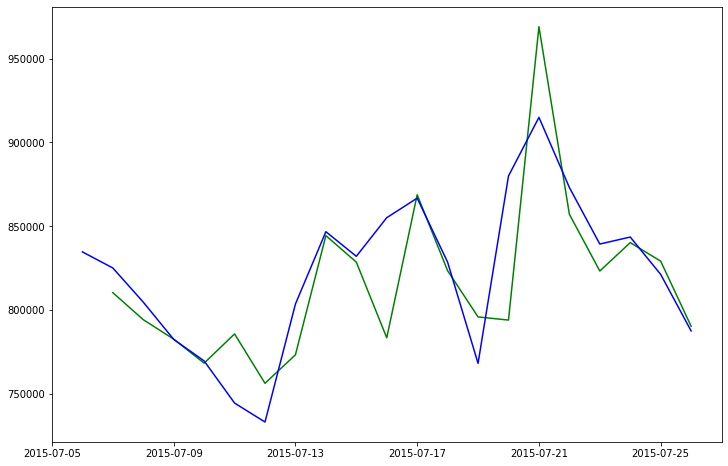

In [51]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(0, 55000)

plt.plot(demand_hat2[1:21], label='Prediction', c='g')
actual = X_train['day_demand'].values
plt.plot(X_train.index[:21], X_train['day_demand'].values[:21], c='b', label='Actual')

----
##### <a id='forecast-SARI_exog'>5B.3 SARIMAX With Exogeneous Data - Forecast  </a>
----

In [52]:
predict_steps = 7*4
predict2 = res2.get_forecast(predict_steps, 
                exog=X_walk1[important_cities].values[:predict_steps, :])
pred_ci2 = np.exp(predict2.conf_int(alpha=0.5))
pred_vals2 = np.exp(predict2.predicted_mean)

In [53]:
aic2 = res2.aic

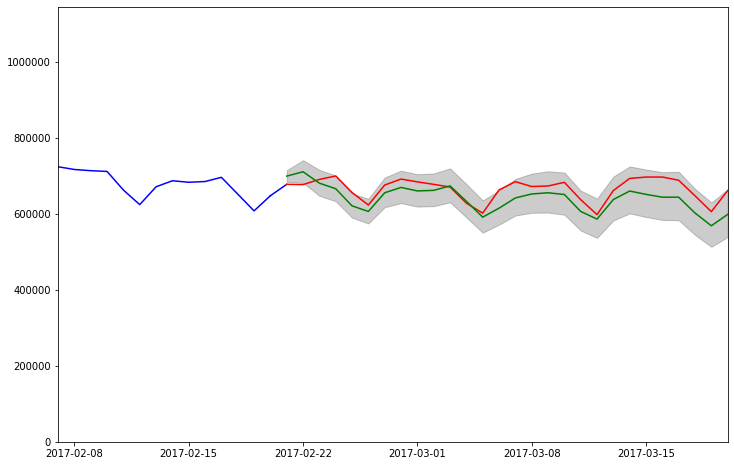

In [54]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci2.iloc[:, 0].values
high_values = pred_ci2.iloc[:, 1].values
pred_times2 = pred_ci2.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times2))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['day_demand']), max(X_walk1['day_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['day_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk1['day_demand'].index[0]], \
          [X_train['day_demand'].values[-1], X_walk1['day_demand'].values[0]], c='b')
plt.plot(X_walk1.index, X_walk1['day_demand'].values, c='r')
plt.plot(pred_times2, pred_vals2.values, c='g')


plt.fill_between(pred_times2, low_values, high_values, color='k', alpha=0.2)

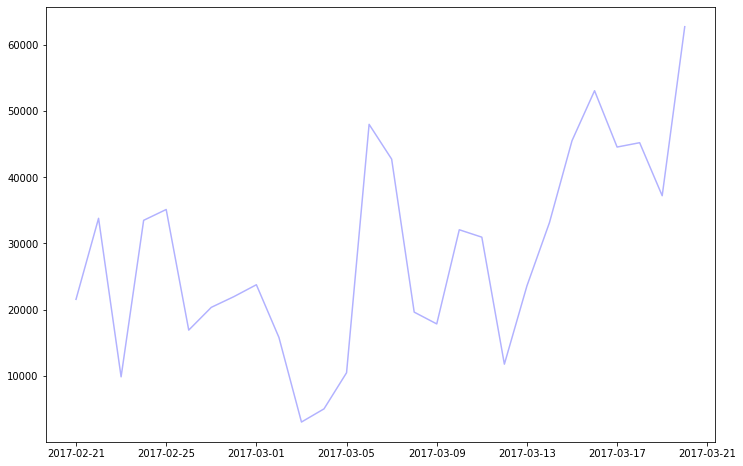

In [55]:
fig = plt.figure(figsize=[12, 8])
residuals2 = [abs(X_walk1['day_demand'].values[x] - pred_vals2.values[x]) for x in range(len(pred_vals2))]
plt.plot(pred_times2, residuals2, c='b', alpha=0.3)
#plt.ylim(0, 10000)

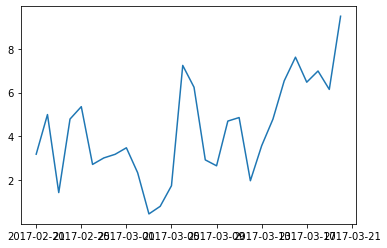

In [56]:
residuals = [abs(X_walk1['day_demand'].values[x] - pred_vals2.values[x]) for x in range(len(pred_vals2))]
percent_error = [residuals[x]/X_walk1['day_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times2, percent_error)
#plt.ylim(0, 7000)

In [57]:
mape2 = np.mean(percent_error[:21])
print(mape2)

3.4116316533951037


----
#### <a id='model-SARI-xexog'>5C. SARIMAX With Extended Exogeneous Data </a>
----

In [58]:
# Use all the dummies for the day of the week but don't use the DOW column
all_exog_columns = X_train.columns[1:-1]

In [59]:
# Define the model for SARIMAX just using the demand data
order_list =[(3,0,0),
             (4,0,0),
             (5,0,0),
             (3,1,0),
             (4,1,0),
             (5,1,0),
             (3,0,1),
             (4,0,1),
             (5,0,1),
             (3,1,1),
             (4,1,1)]

# Define the model for SARIMAX just using the demand data
seasonal_list =[(3,0,0, 7),
                (4,0,0, 7),
                (5,0,0, 7),
                (3,1,0, 7),
                (4,1,0, 7),
                (5,1,0, 7),
                (3,0,1, 7),
                (4,0,1, 7),
                (5,0,1, 7)]

result_dict = order_sweep(SARIMAX, order_list, seasonal_list,  \
        endo_data=X_train['log_demand'], exo_data=X_train[all_exog_columns])


In [60]:
for result in top_results(result_dict, 'aic', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (5, 1, 0), 'seasonal order': (3, 0, 0, 7), 'aic': -2706.1799413410126, 'bic': -2600.8544676079173, 'mse': 0.3944246504543473}
{'order': (5, 1, 0), 'seasonal order': (4, 0, 0, 7), 'aic': -2704.9667596178997, 'bic': -2595.252724479259, 'mse': 0.39442388510542903}
{'order': (5, 1, 0), 'seasonal order': (5, 0, 0, 7), 'aic': -2703.3512172091287, 'bic': -2589.2486206649423, 'mse': 0.3944235171633736}
{'order': (5, 1, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -2699.4717894343034, 'bic': -2585.369192890117, 'mse': 0.3944272836952086}
{'order': (4, 1, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -2689.7701432167914, 'bic': -2580.056108078151, 'mse': 0.3944387416081886}


In [61]:
for result in top_results(result_dict, 'bic', 5) :
    print(result)


{'order': (5, 1, 0), 'seasonal order': (3, 0, 0, 7), 'aic': -2706.1799413410126, 'bic': -2600.8544676079173, 'mse': 0.3944246504543473}
{'order': (5, 1, 0), 'seasonal order': (3, 0, 1, 7), 'aic': -2702.4756564674462, 'bic': -2592.7616213288056, 'mse': 0.3944263102814149}
{'order': (5, 1, 0), 'seasonal order': (5, 0, 0, 7), 'aic': -2703.3512172091287, 'bic': -2589.2486206649423, 'mse': 0.3944235171633736}
{'order': (4, 1, 0), 'seasonal order': (3, 0, 1, 7), 'aic': -2692.3447680499344, 'bic': -2587.0192943168395, 'mse': 0.39443816934254217}
{'order': (3, 1, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -2678.574659637627, 'bic': -2573.249185904532, 'mse': 0.39445181063852935}


In [62]:
for result in top_results(result_dict, 'mse', 5) :
    print(result)


{'order': (5, 0, 0), 'seasonal order': (5, 0, 1, 7), 'aic': -2331.4078392304655, 'bic': -2212.871341219701, 'mse': 0.0010594502676061855}
{'order': (3, 0, 1), 'seasonal order': (4, 0, 1, 7), 'aic': -2334.1840707657348, 'bic': -2224.428054089101, 'mse': 0.0010635629602923108}
{'order': (5, 0, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -2330.697327174607, 'bic': -2216.5510698309076, 'mse': 0.0010637721469461045}
{'order': (4, 0, 1), 'seasonal order': (5, 0, 1, 7), 'aic': -2329.9137932617914, 'bic': -2211.377295251027, 'mse': 0.0010640623678973644}
{'order': (5, 0, 0), 'seasonal order': (3, 0, 1, 7), 'aic': -2324.530478893572, 'bic': -2214.774462216938, 'mse': 0.001076897539720397}


In [72]:
# Now choose the results that seem to work the best above and fit the model
# The top results above are evaluated based on coefficient p-values from fit
best_order3 = (5, 0, 0)
best_seasonal_order3 = (3, 0, 0, 7)
best_exog_columns3 = ['f_high']
model3 = SARIMAX(X_train['log_demand'], order=best_order3, \
            seasonal_order=best_seasonal_order3, exog=X_train[best_exog_columns3])
res3 = model3.fit()

In [73]:
print(res3.summary())

                                     SARIMAX Results                                     
Dep. Variable:                        log_demand   No. Observations:                  596
Model:             SARIMAX(5, 0, 0)x(3, 0, 0, 7)   Log Likelihood                1221.051
Date:                           Tue, 07 Apr 2020   AIC                          -2422.102
Time:                                   16:16:55   BIC                          -2378.200
Sample:                               07-06-2015   HQIC                         -2405.007
                                    - 02-20-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
f_high         0.0020      0.000      6.724      0.000       0.001       0.003
ar.L1          1.4599      0.037     39.178

In [74]:
demand_hat3 = np.exp(res3.fittedvalues)

----
##### <a id='plot-SARI_xexog_fit_zoom'>5C.1 SARIMAX With Extended Exogeneous Data - Fit Plot Close </a>
----

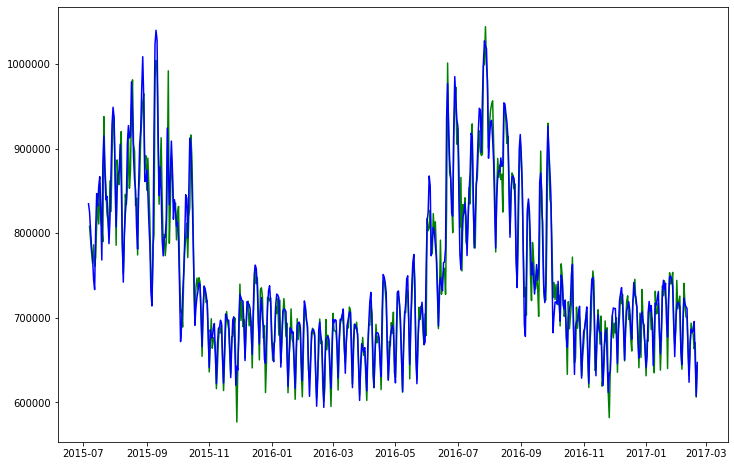

In [75]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(25000, 55000)

plt.plot(demand_hat3[1:], c='g')
plt.plot(X_train.index, X_train['day_demand'].values, c='b')

----

##### <a id='plot-SARI_xexof_fit_wide'>5C.2 SARIMAX With Extended Exogeneous Data - Fit Plot 3 Month </a>

----

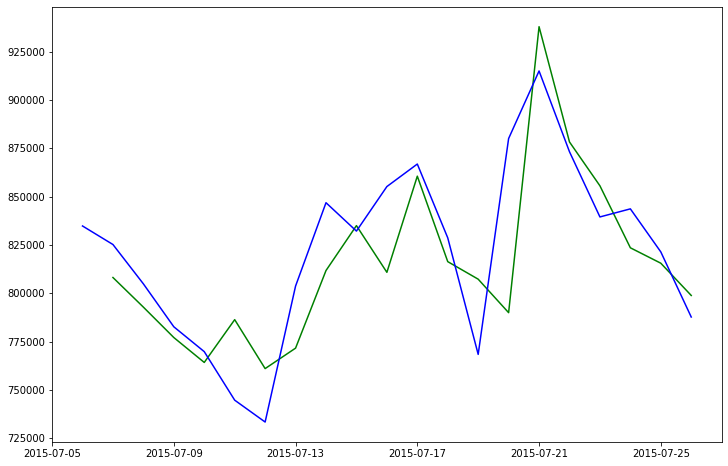

In [76]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(0, 55000)

plt.plot(demand_hat3[1:21], label='Prediction', c='g')
actual = X_train['day_demand'].values
plt.plot(X_train.index[:21], X_train['day_demand'].values[:21], c='b', label='Actual')

In [77]:
# Save the trained model
filename = 'SARIMAX_w_xexog_day.sav'
pickle.dump(model3, open(filename, 'wb'))

----
##### <a id='forecast-SARI_xexog'>5C.3 SARIMAX With Extended Exogeneous Data - Forecast  </a>
----

In [78]:
predict_steps = 7*4
predict3 = res3.get_forecast(predict_steps, 
                exog=X_walk1[best_exog_columns3].values[:predict_steps, :])
pred_ci3 = np.exp(predict3.conf_int(alpha=0.5))
pred_vals3 = np.exp(predict3.predicted_mean)

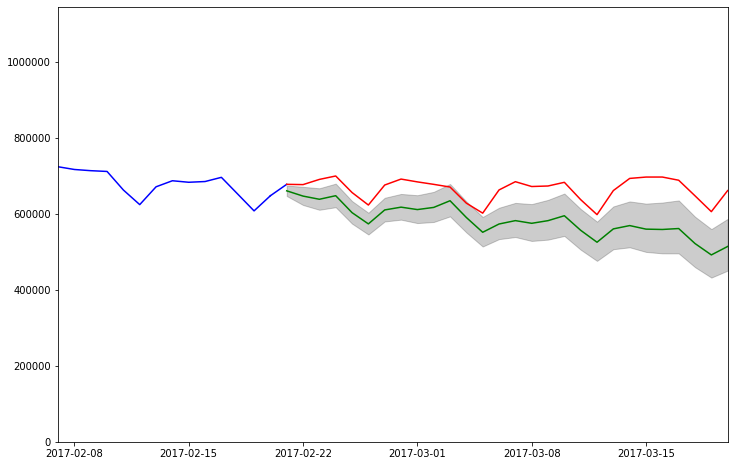

In [79]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci3.iloc[:, 0].values
high_values = pred_ci3.iloc[:, 1].values
pred_times3 = pred_ci3.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times3))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['day_demand']), max(X_walk1['day_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['day_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk1['day_demand'].index[0]], \
          [X_train['day_demand'].values[-1], X_walk1['day_demand'].values[0]], c='b')
plt.plot(X_walk1.index, X_walk1['day_demand'].values, c='r')
plt.plot(pred_times3, pred_vals3.values, c='g')


plt.fill_between(pred_times3, low_values, high_values, color='k', alpha=0.2)

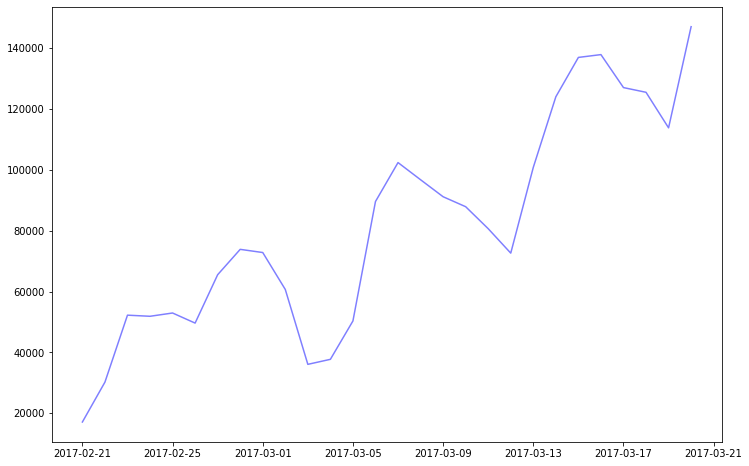

In [80]:
fig = plt.figure(figsize=[12, 8])
residuals3 = [abs(X_walk1['day_demand'].values[x] - pred_vals3.values[x]) for x in range(len(pred_vals3))]
plt.plot(pred_times3, residuals3, c='b', alpha=0.5)
#plt.ylim(0, 10000)

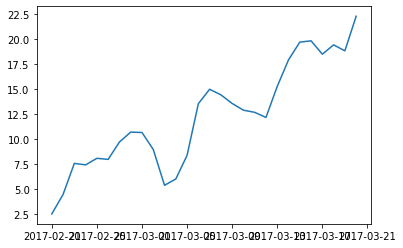

In [81]:
residuals = [abs(X_walk1['day_demand'].values[x] - pred_vals3.values[x]) for x in range(len(pred_vals3))]
percent_error = [residuals[x]/X_walk1['day_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times3, percent_error)
#plt.ylim(0, 7000)

In [82]:
mape3 = np.mean(percent_error[:21])
print(mape3)

9.864958248184339
